# **Tugas Database Multimedia**
* Muhammad Arsal Ranjana Utama
* 121450111
* RA

# Three Ways of Storing and Accessing Lots of Images in Python
> https://realpython.com/storing-images-in-python/


Ketika berurusan dengan kumpulan data gambar yang besar, metode penyimpanan tradisional mungkin tidak dapat menyelesaikannya. Dengan tugas seperti melatih jaringan saraf konvolusional pada kumpulan data besar seperti ImageNet, memuat gambar ke dalam memori dapat memakan waktu. Di sinilah metode penyimpanan alternatif seperti LMDB dan HDF5 berperan. Dalam tutorial ini, kita akan mengeksplorasi mengapa metode ini layak dipertimbangkan, perbedaan kinerjanya dibandingkan dengan penyimpanan tradisional, dan bagaimana metode tersebut ditumpuk dalam hal *disk usage*.

# **Setup**

## A Dataset to Play With

Dalam eksperimen ini, kami akan menggunakan kumpulan data CIFAR-10 dari Canadian Institute for Advanced Research. CIFAR-10 terdiri dari 60.000 gambar berwarna berukuran 32x32 piksel, masing-masing diklasifikasikan ke dalam berbagai kategori objek seperti anjing, kucing, dan pesawat terbang.

Load From Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pickle
from pathlib import Path

# Path to the unzipped CIFAR data
data_dir = Path("/content/drive/MyDrive/Data TBD/cifar-10-batches-py")

# Unpickle function provided by the CIFAR hosts
def unpickle(file):
    with open(file, "rb") as fo:
        dict = pickle.load(fo, encoding="bytes")
    return dict

images, labels = [], []
for batch in data_dir.glob("data_batch_*"):
    batch_data = unpickle(batch)
    for i, flat_im in enumerate(batch_data[b"data"]):
        im_channels = []
        # Each image is flattened, with channels in order of R, G, B
        for j in range(3):
            im_channels.append(
                flat_im[j * 1024 : (j + 1) * 1024].reshape((32, 32))
            )
        # Reconstruct the original image
        images.append(np.dstack((im_channels)))
        # Save the label
        labels.append(batch_data[b"labels"][i])

print("Loaded CIFAR-10 training set:")
print(f" - np.shape(images)     {np.shape(images)}")
print(f" - np.shape(labels)     {np.shape(labels)}")

Loaded CIFAR-10 training set:
 - np.shape(images)     (50000, 32, 32, 3)
 - np.shape(labels)     (50000,)


## Setup for Storing Images on Disk

- **Pillow** (untuk manipulasi gambar)
- **lmdb** (untuk LMDB),
- **h5py** (untuk HDF5)

In [ ]:
! pip install Pillow
! pip install h5py
! pip install lmdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 4.8 MB/s eta 0:00:00


# **Storing a Single Image**

Perbandingan ini  akan berfungsi sebagai pengenalan tentang cara kerja masing-masing metode, dengan contoh kode yang diberikan. Kami akan menguji kinerja pada jumlah file yang berbeda, mulai dari satu gambar hingga 100.000 gambar, menggunakan faktor 10. Untuk eksperimen kami, kami akan menggunakan kumpulan CIFAR-10, dengan total 50.000 gambar, yang dapat kami gandakan hingga mencapai 100.000 gambar .

In [ ]:
from pathlib import Path

disk_dir = Path("data/disk/")
lmdb_dir = Path("data/lmdb/")
hdf5_dir = Path("data/hdf5/")

In [ ]:
disk_dir.mkdir(parents=True, exist_ok=True)
lmdb_dir.mkdir(parents=True, exist_ok=True)
hdf5_dir.mkdir(parents=True, exist_ok=True)

## Storing to Disk

In [ ]:
from PIL import Image
import csv

def store_single_disk(image, image_id, label):
    """ Stores a single image as a .png file on disk.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    Image.fromarray(image).save(disk_dir / f"{image_id}.png")

    with open(disk_dir / f"{image_id}.csv", "wt") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        writer.writerow([label])

> Untuk menyimpan gambar ke disk, kita menggunakan library Pillow untuk menyimpannya dalam format .png dan labelnya disimpan dalam file .csv terpisah.

## Storing to LMDB

In [ ]:
class CIFAR_Image:
    def __init__(self, image, label):
        # Dimensions of image for reconstruction - not really necessary
        # for this dataset, but some datasets may include images of
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]

        self.image = image.tobytes()
        self.label = label

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)

In [ ]:
import lmdb
import pickle

def store_single_lmdb(image, image_id, label):
    """ Stores a single image to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    map_size = image.nbytes * 10

    # Create a new LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        # All key-value pairs need to be strings
        value = CIFAR_Image(image, label)
        key = f"{image_id:08}"
        txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

> Untuk menyimpan gambar ke LMDB, perlu dilakukan proses serialisasi untuk mengubah gambar dan labelnya menjadi string sebelum disimpan ke dalam database LMDB.

## Storing With HDF5

In [ ]:
import h5py

def store_single_hdf5(image, image_id, label):
    """ Stores a single image to an HDF5 file.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
        label       image label
    """
    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "image", np.shape(image), h5py.h5t.STD_U8BE, data=image
    )
    meta_set = file.create_dataset(
        "meta", np.shape(label), h5py.h5t.STD_U8BE, data=label
    )
    file.close()

> Untuk menyimpan gambar ke dalam HDF5, langkah pertama adalah menggunakan library h5py untuk membuat file HDF5. Selanjutnya, kita menyimpan gambar bersama dengan labelnya sebagai dua dataset terpisah di dalam file tersebut.

## Experiments for Storing a Single Image

In [ ]:
_store_single_funcs = dict(
    disk=store_single_disk, lmdb=store_single_lmdb, hdf5=store_single_hdf5
)

In [ ]:
from timeit import timeit

store_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_store_single_funcs[method](image, 0, label)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    store_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.013512245999891093
Method: lmdb, Time usage: 0.007620325000061712
Method: hdf5, Time usage: 0.0023656040000332723


# **Storing Many Images**

>Dalam konteks *storing a single image* / menyimpan satu gambar, hasiil mengungkapkan penggunaan waktu untuk tiga metode: **disk**, **LMDB**, dan **HDF5**. Hasilnya menunjukkan bahwa HDF5 memiliki penggunaan waktu tercepat (0,002 detik), diikuti oleh LMDB (0,007 detik), dan penyimpanan disk memiliki penggunaan waktu paling lambat (0,013 detik).

## Adjusting the Code for Many Images

>Diperlukan sedikit penyesuaian kode dan pembuatan tiga fungsi baru yang dapat menangani sejumlah gambar banyak: store_many_disk(), store_many_lmdb(), dan store_many_hdf5().

In [ ]:
def store_many_disk(images, labels):
    """ Stores an array of images to disk
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Save all the images one by one
    for i, image in enumerate(images):
        Image.fromarray(image).save(disk_dir / f"{i}.png")

    # Save all the labels to the csv file
    with open(disk_dir / f"{num_images}.csv", "w") as csvfile:
        writer = csv.writer(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for label in labels:
            # This typically would be more than just one value per row
            writer.writerow([label])

def store_many_lmdb(images, labels):
    """ Stores an array of images to LMDB.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    map_size = num_images * images[0].nbytes * 10

    # Create a new LMDB DB for all the images
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), map_size=map_size)

    # Same as before — but let's write all the images in a single transaction
    with env.begin(write=True) as txn:
        for i in range(num_images):
            # All key-value pairs need to be Strings
            value = CIFAR_Image(images[i], labels[i])
            key = f"{i:08}"
            txn.put(key.encode("ascii"), pickle.dumps(value))
    env.close()

def store_many_hdf5(images, labels):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

## Preparing the Dataset

>Setelah menyiapkan fungsi penyimpanan untuk gambar yang banyak, langkah selanjutnya adalah memperluas dataset menjadi 100.000 gambar dengan menggandakan array gambar dan label. Ini dilakukan untuk menguji kinerja ketiga metode penyimpanan terhadap jumlah gambar yang besar.

In [ ]:
cutoffs = [10, 100, 1000, 10000, 100000]

# Let's double our images so that we have 100,000
images = np.concatenate((images, images), axis=0)
labels = np.concatenate((labels, labels), axis=0)

# Make sure you actually have 100,000 images and labels
print(np.shape(images))
print(np.shape(labels))

(100000, 32, 32, 3)
(100000,)


## Experiment for Storing Many Images

>Lalu bagaimana perbandingan ketiga metode ketika menyimpan gambar yang berbeda ?

In [ ]:
_store_many_funcs = dict(
    disk=store_many_disk, lmdb=store_many_lmdb, hdf5=store_many_hdf5
)

from timeit import timeit

store_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_store_many_funcs[method](images_, labels_)",
            setup="images_=images[:cutoff]; labels_=labels[:cutoff]",
            number=1,
            globals=globals(),
        )
        store_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.006231326000033732
Method: lmdb, Time usage: 0.008157640000035826
Method: hdf5, Time usage: 0.0022126890000890853
Method: disk, Time usage: 0.039865145000021585
Method: lmdb, Time usage: 0.017080639999903724
Method: hdf5, Time usage: 0.002698586999940744
Method: disk, Time usage: 0.4252777250001145
Method: lmdb, Time usage: 0.04512228399994456
Method: hdf5, Time usage: 0.00611033099994529
Method: disk, Time usage: 8.206039150999914
Method: lmdb, Time usage: 2.4423044600000594
Method: hdf5, Time usage: 0.3088613959998838
Method: disk, Time usage: 55.50677291000011
Method: lmdb, Time usage: 6.033562983000138
Method: hdf5, Time usage: 4.808491384000035


**What if we visualize it ?**

<ipython-input-15-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


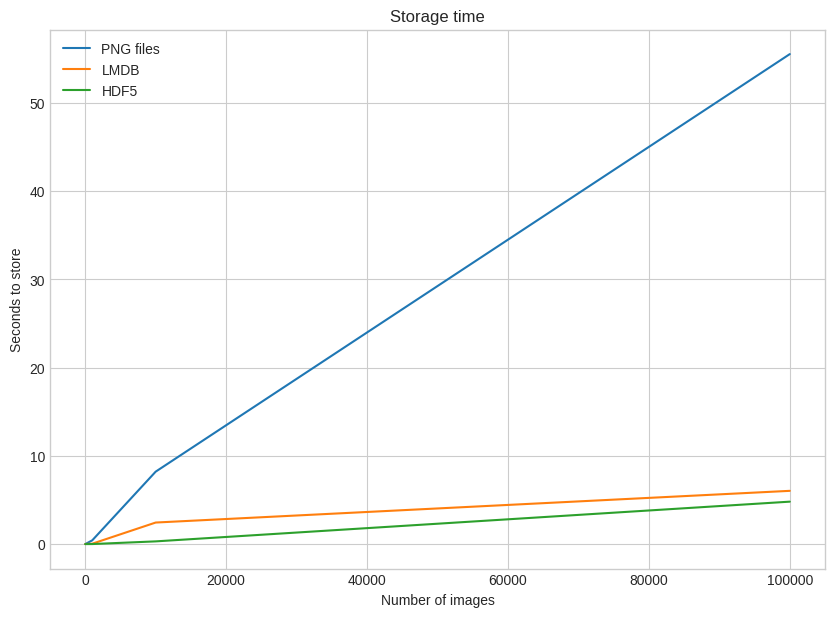

<ipython-input-15-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


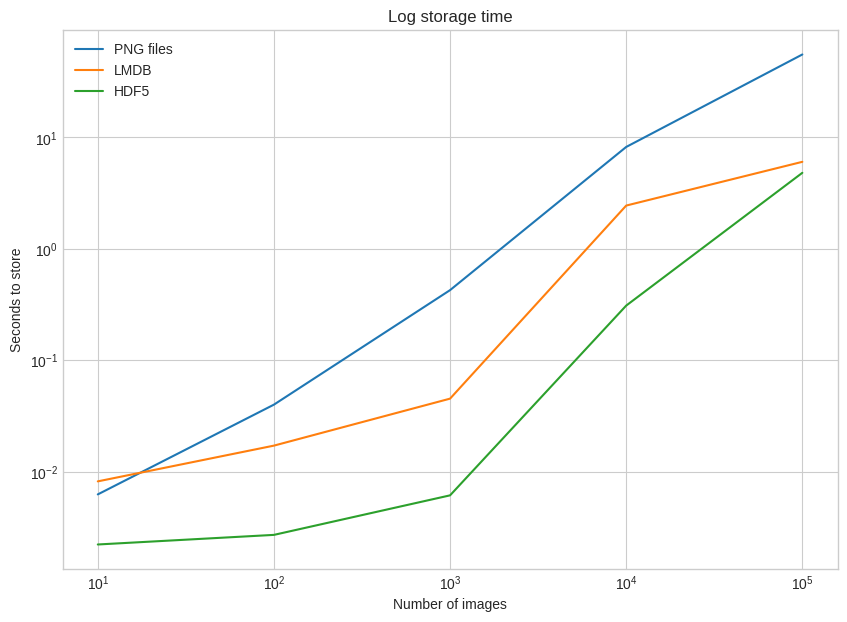

In [ ]:
import matplotlib.pyplot as plt

def plot_with_legend(
    x_range, y_data, legend_labels, x_label, y_label, title, log=False
):
    """ Displays a single plot with multiple datasets and matching legends.
        Parameters:
        --------------
        x_range         list of lists containing x data
        y_data          list of lists containing y values
        legend_labels   list of string legend labels
        x_label         x axis label
        y_label         y axis label
    """
    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(10, 7))

    if len(y_data) != len(legend_labels):
        raise TypeError(
            "Error: number of data sets does not match number of labels."
        )

    all_plots = []
    for data, label in zip(y_data, legend_labels):
        if log:
            temp, = plt.loglog(x_range, data, label=label)
        else:
            temp, = plt.plot(x_range, data, label=label)
        all_plots.append(temp)

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(handles=all_plots)
    plt.show()

# Getting the store timings data to display
disk_x = store_many_timings["disk"]
lmdb_x = store_many_timings["lmdb"]
hdf5_x = store_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Storage time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x, lmdb_x, hdf5_x],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to store",
    "Log storage time",
    log=True,
)

> Plot tersebut menunjukkan waktu penyimpanan yang diperlukan untuk ketiga metode (file PNG pada disk, LMDB, dan HDF5) seiring dengan bertambahnya jumlah gambar secara linier. Pada plot terlihat jelas menunjukkan bahwa file PNG pada metode disk memiliki waktu penyimpanan tertinggi, yang meningkat pesat seiring bertambahnya jumlah gambar. Metode LMDB berkinerja lebih baik daripada file PNG, namun metode HDF5 mengungguli keduanya, memerlukan waktu penyimpanan paling sedikit bahkan untuk gambar dalam jumlah besar.

>Untuk mempermudah perbedaan waktu penyimpanan pada jumlah gambar, kita dapat menampilkan plot dengan skala logaritmik pada sumbu y. Plot ini menyoroti keunggulan kinerja HDF5 yang signifikan dibandingkan dua metode lainnya, terutama untuk kumpulan data yang lebih kecil.

# **Reading a Single Image**

## Reading From Disk

In [ ]:
def read_single_disk(image_id):
    """ Stores a single image to disk.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    image = np.array(Image.open(disk_dir / f"{image_id}.png"))

    with open(disk_dir / f"{image_id}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        label = int(next(reader)[0])

    return image, label

## Reading From LMDB

In [ ]:
def read_single_lmdb(image_id):
    """ Stores a single image to LMDB.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the LMDB environment
    env = lmdb.open(str(lmdb_dir / f"single_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Encode the key the same way as we stored it
        data = txn.get(f"{image_id:08}".encode("ascii"))
        # Remember it's a CIFAR_Image object that is loaded
        cifar_image = pickle.loads(data)
        # Retrieve the relevant bits
        image = cifar_image.get_image()
        label = cifar_image.label
    env.close()

    return image, label

## Reading From HDF5

In [ ]:
def read_single_hdf5(image_id):
    """ Stores a single image to HDF5.
        Parameters:
        ---------------
        image_id    integer unique ID for image

        Returns:
        ----------
        image       image array, (32, 32, 3) to be stored
        label       associated meta data, int label
    """
    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{image_id}.h5", "r+")

    image = np.array(file["/image"]).astype("uint8")
    label = int(np.array(file["/meta"]).astype("uint8"))

    return image, label

In [ ]:
_read_single_funcs = dict(
    disk=read_single_disk, lmdb=read_single_lmdb, hdf5=read_single_hdf5
)

## Experiment for Reading a Single Image

> Lalu bagaimana performa read pada ketiga metode tersebut ?

In [ ]:
from timeit import timeit

read_single_timings = dict()

for method in ("disk", "lmdb", "hdf5"):
    t = timeit(
        "_read_single_funcs[method](0)",
        setup="image=images[0]; label=labels[0]",
        number=1,
        globals=globals(),
    )
    read_single_timings[method] = t
    print(f"Method: {method}, Time usage: {t}")

Method: disk, Time usage: 0.0017979159999867989
Method: lmdb, Time usage: 0.0003480940001736599
Method: hdf5, Time usage: 0.0019738959999813233


> Dengan kode diatas kita dapat mengetahui performa ketiga metode ketika membaca / read sebuah gambar. Dapat terlihat pada ketiga metode tersebut tidak berbeda secara signifikan ketika membaca sebuah gambar, bahkan metode tradisional menggungguli metode lainnya secara marginal. Aneh bukan ?

# **Reading Many Images**

Lalu bagaimana jika kita membaca gambar dalam jumlah yang banyak ?

## Adjusting the Code for Many Images

In [ ]:
def read_many_disk(num_images):
    """ Reads image from disk.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Loop over all IDs and read each image in one by one
    for image_id in range(num_images):
        images.append(np.array(Image.open(disk_dir / f"{image_id}.png")))

    with open(disk_dir / f"{num_images}.csv", "r") as csvfile:
        reader = csv.reader(
            csvfile, delimiter=" ", quotechar="|", quoting=csv.QUOTE_MINIMAL
        )
        for row in reader:
            labels.append(int(row[0]))
    return images, labels

def read_many_lmdb(num_images):
    """ Reads image from LMDB.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []
    env = lmdb.open(str(lmdb_dir / f"{num_images}_lmdb"), readonly=True)

    # Start a new read transaction
    with env.begin() as txn:
        # Read all images in one single transaction, with one lock
        # We could split this up into multiple transactions if needed
        for image_id in range(num_images):
            data = txn.get(f"{image_id:08}".encode("ascii"))
            # Remember that it's a CIFAR_Image object
            # that is stored as the value
            cifar_image = pickle.loads(data)
            # Retrieve the relevant bits
            images.append(cifar_image.get_image())
            labels.append(cifar_image.label)
    env.close()
    return images, labels

def read_many_hdf5(num_images):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{num_images}_many.h5", "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

_read_many_funcs = dict(
    disk=read_many_disk, lmdb=read_many_lmdb, hdf5=read_many_hdf5
)

## Experiment for Reading Many Images

In [ ]:
from timeit import timeit

read_many_timings = {"disk": [], "lmdb": [], "hdf5": []}

for cutoff in cutoffs:
    for method in ("disk", "lmdb", "hdf5"):
        t = timeit(
            "_read_many_funcs[method](num_images)",
            setup="num_images=cutoff",
            number=1,
            globals=globals(),
        )
        read_many_timings[method].append(t)

        # Print out the method, cutoff, and elapsed time
        print(f"Method: {method}, No. images: {cutoff}, Time usage: {t}")

Method: disk, No. images: 10, Time usage: 0.008943990000034319
Method: lmdb, No. images: 10, Time usage: 0.007024887999932616
Method: hdf5, No. images: 10, Time usage: 0.00245715799997015
Method: disk, No. images: 100, Time usage: 0.045927525000024616
Method: lmdb, No. images: 100, Time usage: 0.010510112000019944
Method: hdf5, No. images: 100, Time usage: 0.008543084999928396
Method: disk, No. images: 1000, Time usage: 0.4335843720000412
Method: lmdb, No. images: 1000, Time usage: 0.0510746410000138
Method: hdf5, No. images: 1000, Time usage: 0.03078050199997051
Method: disk, No. images: 10000, Time usage: 4.393096988000025
Method: lmdb, No. images: 10000, Time usage: 0.24999368500016317
Method: hdf5, No. images: 10000, Time usage: 0.2676439900001242
Method: disk, No. images: 100000, Time usage: 33.854493907000005
Method: lmdb, No. images: 100000, Time usage: 1.526834794000024
Method: hdf5, No. images: 100000, Time usage: 1.6082435040000291


> Dengan membaca banyak gambar dibandingkan membaca sebuah gambar, ketiga metode tersebut akhirnya teruji dengan benar. Bila ditinjau secara kilas pada saat membaca 100000 gambar, waktu eksekusi metode tradisional / disk meledak secara eksponensial. Hal tersebut sangat terlihat beda dengan metode HDF5 dan lmdb.

<ipython-input-15-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


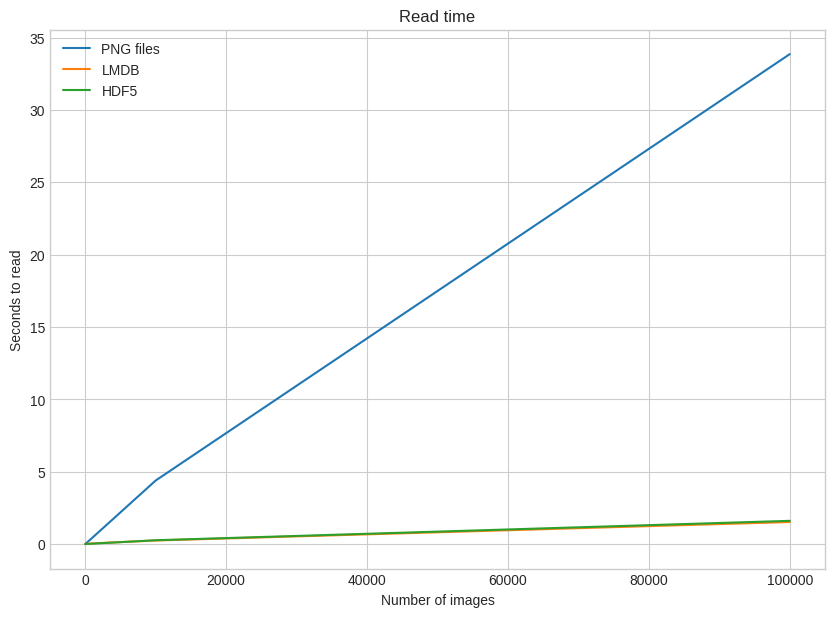

<ipython-input-15-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


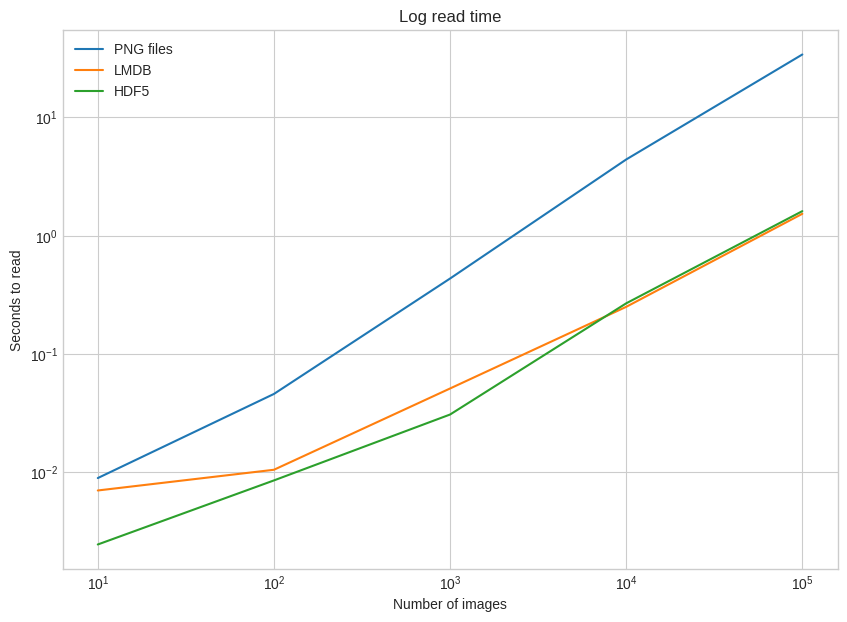

In [ ]:
disk_x_r = read_many_timings["disk"]
lmdb_x_r = read_many_timings["lmdb"]
hdf5_x_r = read_many_timings["hdf5"]

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Read time",
    log=False,
)

plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r],
    ["PNG files", "LMDB", "HDF5"],
    "Number of images",
    "Seconds to read",
    "Log read time",
    log=True,
)

> Terlihat pada visualisasi Read Time diatas, metode HDF5 dan LMDB relatif sama dalam kemampuan membaca gambar seiring betambahnya gambar tersebut. Namun, metode tradisional meledak secara eksponensial dalam kemampuan membaca gambar seiring bertambahnya gambar tersebut.

> Untuk mempermudah perbedaan waktu membaca pada gambar yang banyak, kita dapat menampilkan plot dengan skala logaritmik pada sumbu y kembali. Seperti pada sebelumnya, pada plot ini menyoroti keunggulan kinerja HDF5 dan LMDB yang signifikan lebih cepat dibandingkan dengan metode tradisional

<ipython-input-15-99d89538a067>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


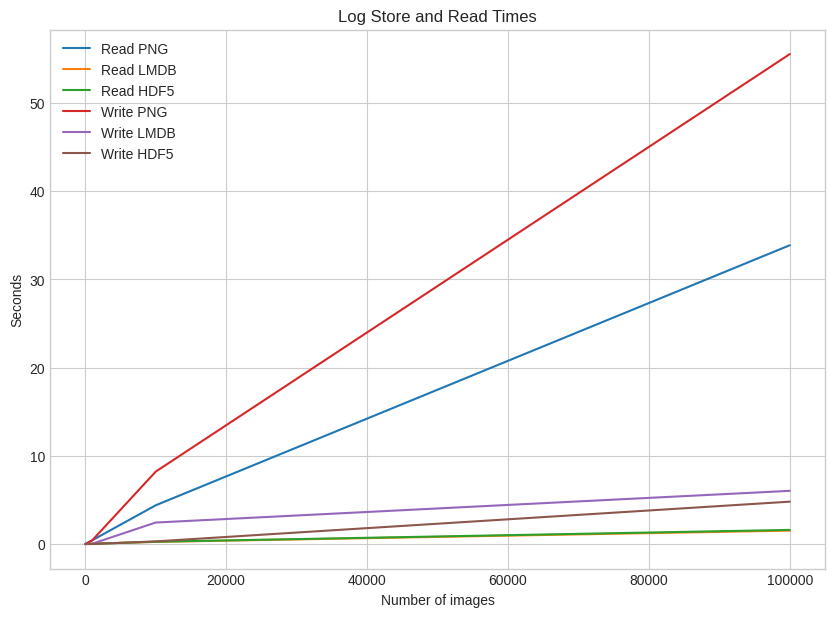

In [33]:
plot_with_legend(
    cutoffs,
    [disk_x_r, lmdb_x_r, hdf5_x_r, disk_x, lmdb_x, hdf5_x],
    [
        "Read PNG",
        "Read LMDB",
        "Read HDF5",
        "Write PNG",
        "Write LMDB",
        "Write HDF5",
    ],
    "Number of images",
    "Seconds",
    "Log Store and Read Times",
    log=False,
)

> Visualisasi Menyimpan dan Membaca dalam skala logaritmik pada sumbu y. Terlihat secara jelas bahwa metode tradisional jauh dalam segi menyimpan dan membaca. Bila ditinjau secara marginal, metode HDF5 lebih unggul dibandingkan metode LMDB dalam segi membaca gambar gambar tersebut.

# **Considering Disk Usage**

Selain kecepatan komputasi, metrik kinerja penting lainnya adalah penggunaan ruang disk / disk space usage, terutama saat menangani dataset besar. Bayangkan Anda memiliki kumpulan data gambar berukuran 3 TB yang sudah disimpan di disk. Saat menggunakan metode penyimpanan alternatif, seperti LMDB atau HDF5, pada dasarnya Anda membuat salinan kumpulan data lain, sehingga menambah persyaratan penyimpanan. Pertukaran ini menawarkan manfaat kinerja yang signifikan namun memerlukan ruang disk yang cukup. Di bawah ini adalah ruang disk yang digunakan oleh setiap metode penyimpanan pada jumlah gambar yang berbeda:

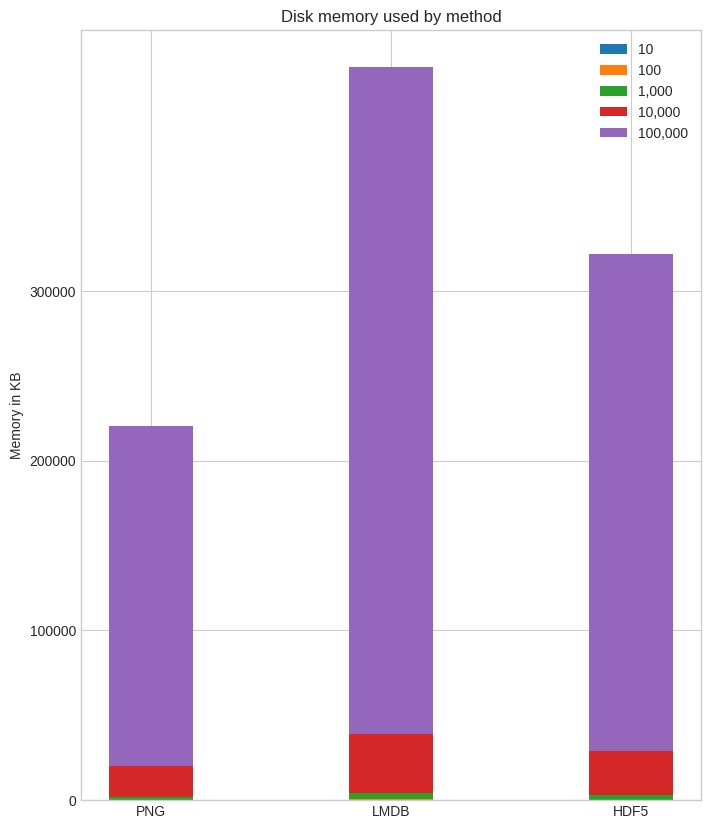

In [ ]:
# Memory used in KB
disk_mem = [24, 204, 2004, 20032, 200296]
lmdb_mem = [60, 420, 4000, 39000, 393000]
hdf5_mem = [36, 304, 2900, 29000, 293000]

X = [disk_mem, lmdb_mem, hdf5_mem]

ind = np.arange(3)
width = 0.35

plt.subplots(figsize=(8, 10))
plots = [plt.bar(ind, [row[0] for row in X], width)]
for i in range(1, len(cutoffs)):
    plots.append(
        plt.bar(
            ind, [row[i] for row in X], width, bottom=[row[i - 1] for row in X]
        )
    )

plt.ylabel("Memory in KB")
plt.title("Disk memory used by method")
plt.xticks(ind, ("PNG", "LMDB", "HDF5"))
plt.yticks(np.arange(0, 400000, 100000))

plt.legend(
    [plot[0] for plot in plots], ("10", "100", "1,000", "10,000", "100,000")
)
plt.show()

> Plot tersebut membandingkan penggunaan memori disk dari tiga metode tersebut pada berbagai ukuran data mulai dari 10 hingga 100.000 gambar. Untuk ukuran data 10 gambar dan 100 gambar, tidak terlihat jelas metode mana yang mengkonsumsi memori disk paling sedikit. Namun, seiring bertambahnya ukuran data menjadi 1.000, 10.000, dan 100.000 gambar, metode HDF5 menjadi yang paling efisien dalam hal penggunaan memori disk, sehingga memerlukan ruang disk yang jauh lebih sedikit dibandingkan dua metode lainnya. Dengan kecepatan komputasi metode LMDB yang hampir sama dengan HDF5, akan tetapi ada yang dikorbankan dalam metode LMDB ini yaitu penggunaan memorinya yang tinggi dari HDF5. Dan dari plot tersebut kita dapat mengetahui secara singkatnya, meskipun metode tradisional lebih hemat memori untuk kumpulan data kecil, HDF5 mengungguli dua metode lainnya dengan memanfaatkan ruang disk secara lebih efisien saat menangani kumpulan data yang lebih besar.